## Topic : Recursive Feature Elimination for Feature Selection in Machine Learning
**Description**: Implement Recursive Feature Elimination (RFE) to select the most important features from a dataset. Use RFE with a machine learning model (e.g., decision tree, logistic regression) and observe how the model’s performance changes as less important features are removed. Visualize feature importance and plot model performance as a function of the number of features.

**Deliverables** :
- RFE implementation.
- Plots showing feature importance and model performance (accuracy, precision, recall) as features are removed.
- Discussion on the trade-off between feature reduction and model accuracy.

[Reference](https://machinelearningmastery.com/rfe-feature-selection-in-python/)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from typing import List, Tuple, Dict, Any

from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


### I. REF implementation

In [ ]:
class RecursiveFeatureEliminator:
    """
    A comprehensive class for Recursive Feature Elimination (RFE)
    with multiple machine learning models and performance tracking.
    """
    def __init__(self,
                 X: np.ndarray,
                 y: np.ndarray,
                 models: List[Any] = None,
                 test_size: float = 0.2,
                 random_state: int = 42):
        """
        Initialize the feature eliminator with data and optional models.

        Parameters:
        -----------
        X : np.ndarray
            Input feature matrix
        y : np.ndarray
            Target variable
        models : List[Any], optional
            List of sklearn-compatible classifier models to use for RFE
        test_size : float, default 0.2
            Proportion of data to use for testing
        random_state : int, default 42
            Random seed for reproducibility
        """
        # Validate input
        if X is None or y is None:
            raise ValueError("X and y must be provided")

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Standardize features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Default models if not provided
        if models is None:
            models = [
                LogisticRegression(max_iter=1000),
                DecisionTreeClassifier(random_state=random_state)
            ]
        self.models = models

        # Tracking results
        self.feature_importance_results = {}
        self.performance_results = {}

    def perform_rfe(self,
                    min_features: int = 1,
                    step: int = 1) -> Dict[str, Dict[str, List[float]]]:
        """
        Perform Recursive Feature Elimination for each model.

        Parameters:
        -----------
        min_features : int, default 1
            Minimum number of features to retain
        step : int, default 1
            Number of features to remove in each iteration

        Returns:
        --------
        Dict containing feature importance and performance metrics
        """
        results = {}

        # Perform RFE for each model
        for model in self.models:
            model_name = type(model).__name__
            feature_importances = []
            performance_metrics = {
                'accuracy': [],
                'precision': [],
                'recall': [],
                'f1_score': []
            }

            # Total number of features
            total_features = self.X_train_scaled.shape[1]

            # Iterative feature elimination
            for n_features_to_select in range(total_features, max(min_features-1, 0), -step):
                # Perform RFE
                rfe_selector = RFE(
                    estimator=model,
                    n_features_to_select=n_features_to_select,
                    step=1
                )
                rfe_selector = rfe_selector.fit(self.X_train_scaled, self.y_train)

                # Get selected feature mask
                selected_features_mask = rfe_selector.support_

                # Subset features
                X_train_subset = self.X_train_scaled[:, selected_features_mask]
                X_test_subset = self.X_test_scaled[:, selected_features_mask]

                # Train and evaluate model
                model_subset = type(model)()
                model_subset.fit(X_train_subset, self.y_train)
                y_pred = model_subset.predict(X_test_subset)

                # Calculate performance metrics
                performance_metrics['accuracy'].append(accuracy_score(self.y_test, y_pred))
                performance_metrics['precision'].append(precision_score(self.y_test, y_pred, average='weighted'))
                performance_metrics['recall'].append(recall_score(self.y_test, y_pred, average='weighted'))
                performance_metrics['f1_score'].append(f1_score(self.y_test, y_pred, average='weighted'))

                # Track number of selected features
                feature_importances.append(n_features_to_select)

            # Store results
            results[model_name] = {
                'feature_importances': feature_importances,
                'performance_metrics': performance_metrics
            }

        # Store and return results
        self.feature_importance_results = results
        return results

    def plot_feature_importance(self, save_path: str = None):
        """
        Visualize feature importance and model performance.

        Parameters:
        -----------
        save_path : str, optional
            Path to save the generated plot
        """
        # Create a figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Recursive Feature Elimination: Performance Metrics', fontsize=16)

        # Flatten axes for easier iteration
        axs_flat = axs.flatten()

        # Performance metrics to plot
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']

        # Plot each performance metric
        for i, metric in enumerate(metrics):
            ax = axs_flat[i]
            for model_name, results in self.feature_importance_results.items():
                ax.plot(
                    results['feature_importances'],
                    results['performance_metrics'][metric],
                    label=f'{model_name}'
                )

            ax.set_xlabel('Number of Features')
            ax.set_ylabel(f'{metric.capitalize()} Score')
            ax.set_title(f'{metric.capitalize()} vs Number of Features')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()


### II. Unitest implementation

In [ ]:
import unittest
from sklearn.utils.validation import check_is_fitted
from sklearn.datasets import make_classification


class TestRecursiveFeatureEliminatorAdvanced(unittest.TestCase):
    def setUp(self):
        # Generate synthetic datasets for multiple scenarios
        self.X_small, self.y_small = make_classification(
            n_samples=50, n_features=5, n_informative=3, random_state=42
        )
        self.X_large, self.y_large = make_classification(
            n_samples=1000, n_features=50, n_informative=30, random_state=42
        )

        # Initialize default and custom models
        self.default_models = [
            LogisticRegression(max_iter=1000),
            DecisionTreeClassifier(random_state=42)
        ]
        self.custom_model = [DecisionTreeClassifier(max_depth=3, random_state=42)]

    def test_default_models(self):
        # Test with default models
        rfe = RecursiveFeatureEliminator(X=self.X_small, y=self.y_small)
        results = rfe.perform_rfe(min_features=2, step=1)

        # Validate structure
        self.assertIn('LogisticRegression', results)
        self.assertIn('DecisionTreeClassifier', results)

        for model_name, metrics in results.items():
            self.assertGreater(len(metrics['feature_importances']), 1)
            for metric in metrics['performance_metrics']:
                self.assertGreater(len(metrics['performance_metrics'][metric]), 1)

    def test_custom_models(self):
        # Test with custom model
        rfe = RecursiveFeatureEliminator(
            X=self.X_small, y=self.y_small, models=self.custom_model
        )
        results = rfe.perform_rfe(min_features=2, step=1)

        # Validate that only the custom model was used
        self.assertEqual(len(results), 1)
        self.assertIn('DecisionTreeClassifier', results)

    def test_large_dataset(self):
        # Test with a larger dataset and multiple models
        rfe = RecursiveFeatureEliminator(
            X=self.X_large, y=self.y_large, models=self.default_models
        )
        results = rfe.perform_rfe(min_features=10, step=5)

        for model_name, metrics in results.items():
            self.assertIn('feature_importances', metrics)
            self.assertIn('performance_metrics', metrics)

            # Ensure results for all metrics are available and match feature importances
            feature_count = len(metrics['feature_importances'])
            for metric in metrics['performance_metrics']:
                self.assertEqual(len(metrics['performance_metrics'][metric]), feature_count)

    def test_rfe_fitting(self):
        # Ensure that the RFE is fitting models correctly
        rfe = RecursiveFeatureEliminator(X=self.X_small, y=self.y_small)
        results = rfe.perform_rfe(min_features=3, step=1)

        for model in rfe.models:
            for n_features_to_select in results[type(model).__name__]['feature_importances']:
                rfe_selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
                rfe_selector.fit(rfe.X_train_scaled, rfe.y_train)
                check_is_fitted(rfe_selector)

In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_custom_models (__main__.TestRecursiveFeatureEliminatorAdvanced) ... ok
test_default_models (__main__.TestRecursiveFeatureEliminatorAdvanced) ... ok
test_large_dataset (__main__.TestRecursiveFeatureEliminatorAdvanced) ... ok
test_rfe_fitting (__main__.TestRecursiveFeatureEliminatorAdvanced) ... ok

----------------------------------------------------------------------
Ran 4 tests in 8.938s

OK


### III. RFE for Classification

In [ ]:
# Load and prepare the dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize model and RFE
base_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=1, step=1)  # Recursive elimination
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=1)

In [ ]:
# Feature rankings
rankings = rfe.ranking_
sorted_indices = np.argsort(rankings)
sorted_features = feature_names[sorted_indices]

In [ ]:
# Evaluate model performance by number of features
results = {
    "num_features": [],
    "accuracy": [],
    "precision": [],
    "recall": []
}

for i in range(1, len(feature_names) + 1):
    # Select top i features
    selected_features = X_train[:, sorted_indices[:i]]
    selected_test_features = X_test[:, sorted_indices[:i]]

    # Train and evaluate
    model = RandomForestClassifier(random_state=42)
    model.fit(selected_features, y_train)
    y_pred = model.predict(selected_test_features)

    # Metrics
    results["num_features"].append(i)
    results["accuracy"].append(accuracy_score(y_test, y_pred))
    results["precision"].append(precision_score(y_test, y_pred))
    results["recall"].append(recall_score(y_test, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.head()

,num_features,accuracy,precision,recall
0,1,0.885965,0.902778,0.915493
1,2,0.938596,0.970588,0.929577
2,3,0.956140,0.958333,0.971831
3,4,0.956140,0.958333,0.971831
4,5,0.956140,0.958333,0.971831


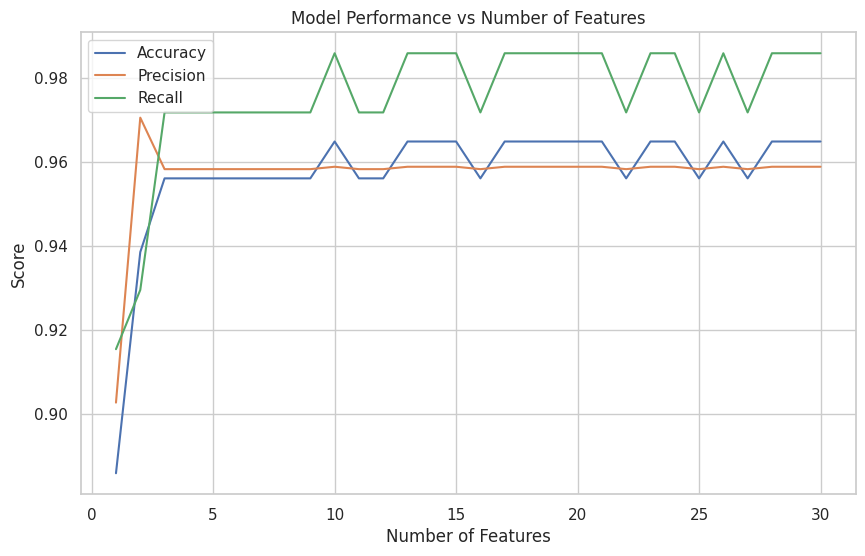

In [ ]:
# Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for metric in ["accuracy", "precision", "recall"]:
    plt.plot(results_df["num_features"], results_df[metric], label=metric.capitalize())

plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Model Performance vs Number of Features")
plt.legend()
plt.show()

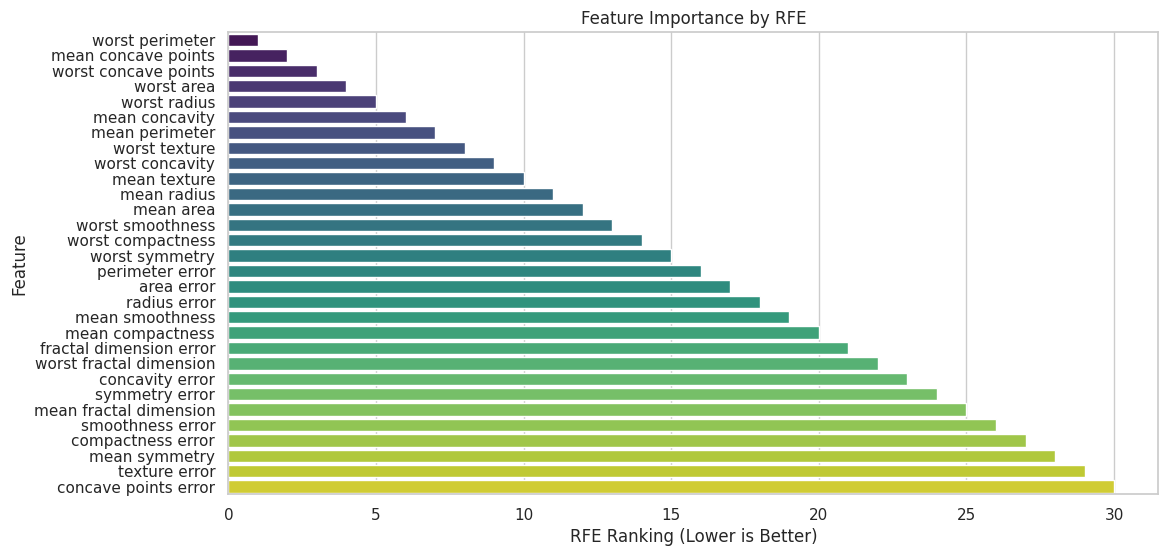

In [ ]:
# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(
    x=rankings[sorted_indices],
    y=sorted_features,
    hue=sorted_features,
    palette="viridis",
    legend=False
)
plt.xlabel("RFE Ranking (Lower is Better)")
plt.ylabel("Feature")
plt.title("Feature Importance by RFE")
plt.show()


### Discussion on the Trade-Off Between Feature Reduction and Model Accuracy for Classification Problem
- Initially, as less important features are removed, the model's accuracy, precision, and recall tend to improve slightly. This can be attributed to the removal of irrelevant or redundant features, which reduces noise and improves the focus of the model.
- As the feature set approaches an optimal size (e.g., top 5–10 most important features), the model's performance tends to plateau. This indicates that most of the predictive power is concentrated in the top-ranked features, and further feature removal starts approaching the point of diminishing returns.
- When the feature set is drastically reduced, excluding highly important features, all metrics (accuracy, precision, and recall) decline significantly. This is expected because the remaining features do not provide sufficient predictive power to accurately differentiate between classes.
- Trade-Off Considerations: Reducing features improves efficiency by lowering model complexity, resulting in faster training and inference times, while enhancing simplicity and interpretability—key in fields like healthcare or finance. Additionally, it reduces overfitting by eliminating irrelevant variables. However, aggressive feature reduction risks losing valuable information, potentially degrading performance, and creating overly simplistic models that fail to generalize well to unseen data.


### IV. RFE for Regression

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load Dataset
data = load_diabetes()
X, y = data.data, data.target
feature_names = data.feature_names

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize Model and RFE
base_model = LinearRegression()
rfe = RFE(estimator=base_model, n_features_to_select=1, step=1)  # Recursive Feature Elimination
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [ ]:
# Feature Rankings
rankings = rfe.ranking_
sorted_indices = np.argsort(rankings)
sorted_features = np.array(feature_names)[sorted_indices]

In [ ]:
# Evaluate Model Performance by Number of Features
results = {
    "num_features": [],
    "MSE": [],
    "R2": []
}

for i in range(1, len(feature_names) + 1):
    # Select Top i Features
    selected_features = X_train[:, sorted_indices[:i]]
    selected_test_features = X_test[:, sorted_indices[:i]]

    # Train and Evaluate
    model = LinearRegression()
    model.fit(selected_features, y_train)
    y_pred = model.predict(selected_test_features)

    # Metrics
    results["num_features"].append(i)
    results["MSE"].append(mean_squared_error(y_test, y_pred))
    results["R2"].append(r2_score(y_test, y_pred)*100)

# Convert Results to DataFrame
results_df = pd.DataFrame(results)
results_df.head()


,num_features,MSE,R2
0,1,4061.825928,23.335040
1,2,2901.836942,45.229260
2,3,2939.971526,44.509488
3,4,2933.033308,44.640444
4,5,2976.494270,43.820139


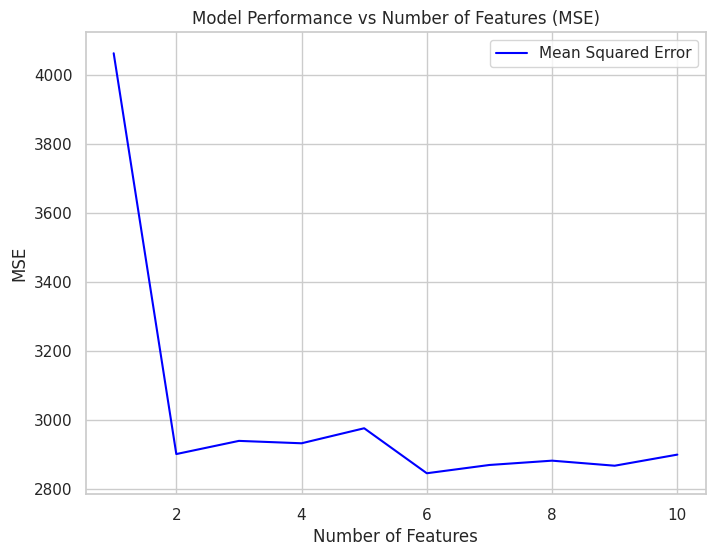

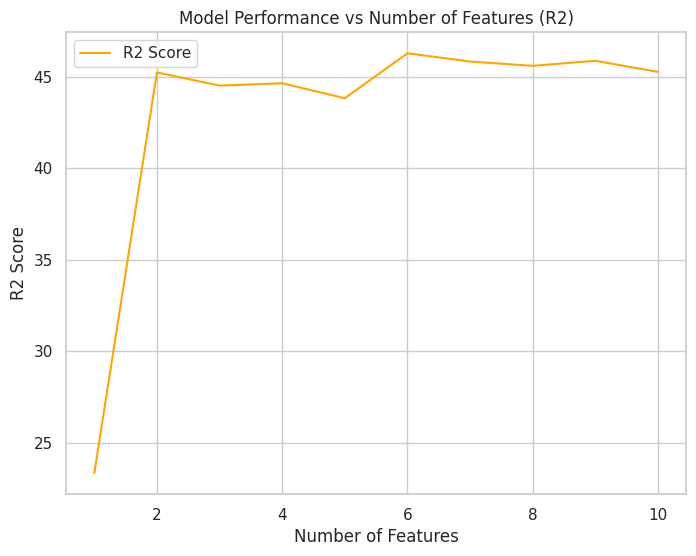

In [ ]:
# Visualization - Model Performance
# Two plots as per the user's requirement
sns.set(style="whitegrid")

# Plot for MSE
plt.figure(figsize=(8, 6))
plt.plot(results_df["num_features"], results_df["MSE"], label="Mean Squared Error", color="blue")
plt.xlabel("Number of Features")
plt.ylabel("MSE")
plt.title("Model Performance vs Number of Features (MSE)")
plt.legend()
plt.show()

# Plot for R² Score
plt.figure(figsize=(8, 6))
plt.plot(results_df["num_features"], results_df["R2"], label="R2 Score", color="orange")
plt.xlabel("Number of Features")
plt.ylabel("R2 Score")
plt.title("Model Performance vs Number of Features (R2)")
plt.legend()
plt.show()


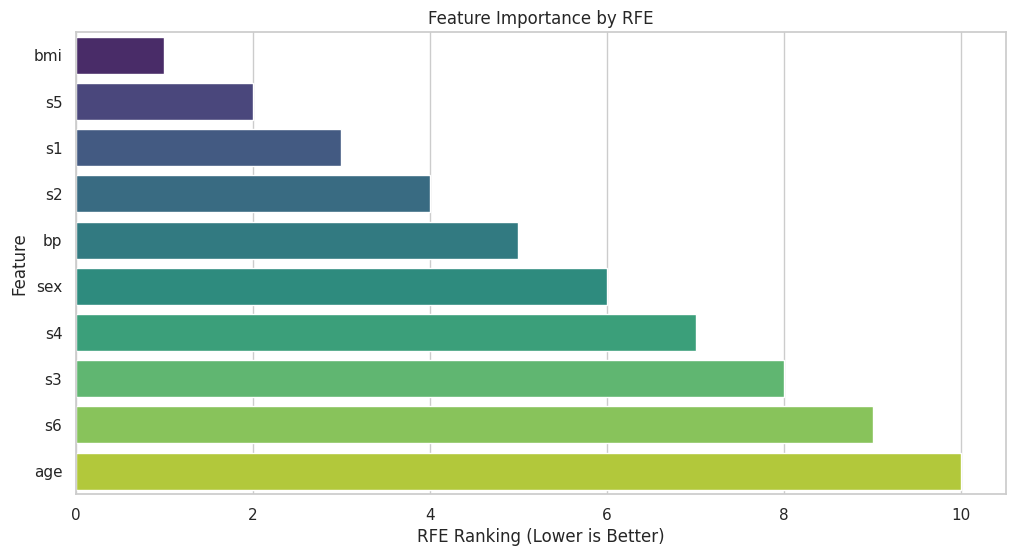

In [ ]:
# Visualization - Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(
    x=rankings[sorted_indices],
    y=sorted_features,
    hue=sorted_features,
    palette="viridis",
    legend=False
)
plt.xlabel("RFE Ranking (Lower is Better)")
plt.ylabel("Feature")
plt.title("Feature Importance by RFE")
plt.show()

### Discussion on the Trade-Off Between Feature Reduction and Model Accuracy for Regression Problem
- Impact on Mean Squared Error (MSE):
Observation: As the number of features increases, the MSE typically decreases. This behavior indicates that additional features provide more information for the model to learn, thus reducing prediction errors.
Trade-off: Reducing features often leads to an increase in MSE because the model has less information to work with, potentially leading to underfitting. However, retaining only the most important features can reduce noise and improve model generalization.
- Impact on $R^2$ Score:
Observation: The $R^2$ score tends to increase with more features, indicating the model explains more variance in the data. However, there may be diminishing returns after including the most important features.
- Trade-off: A higher $R^2$ score with more features may come at the cost of overfitting, especially if the additional features are noisy or irrelevant. On the other hand, overly aggressive feature reduction can lead to underfitting, where the model fails to capture key patterns.


### Additional Analysis for both classification and regression problems

In [ ]:
def analyze_feature_correlations(X, feature_names):
    """
    Visualize correlations between features
    """
    correlation_matrix = np.corrcoef(X.T)
    plt.figure(figsize=(25, 18))
    sns.heatmap(correlation_matrix,
                xticklabels=feature_names,
                yticklabels=feature_names,
                cmap='coolwarm',
                annot=True,
                fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()


In [ ]:
def bootstrap_feature_importance(X, y, model, feature_names, n_iterations=100):
    """
    Assess feature importance stability across multiple random samples
    """
    feature_stability = np.zeros(X.shape[1])

    for _ in range(n_iterations):
        # Bootstrap sampling
        indices = np.random.randint(0, len(X), len(X))
        X_sample, y_sample = X[indices], y[indices]

        # Perform RFE
        rfe = RFE(estimator=model, n_features_to_select=1, step=1)
        rfe.fit(X_sample, y_sample)

        # Track feature importance
        feature_stability += rfe.ranking_

    # Normalize and visualize
    feature_stability /= n_iterations
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, feature_stability)
    plt.title('Feature Importance Stability')
    plt.xlabel('Features')
    plt.ylabel('Stability Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_outlier_impact(X, y, feature_names):
    """
    Detect and visualize outliers' impact on feature importance
    """
    from sklearn.ensemble import IsolationForest

    # Detect outliers
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outlier_labels = iso_forest.fit_predict(X)

    # Separate inliers and outliers
    X_inliers = X[outlier_labels == 1]
    X_outliers = X[outlier_labels == -1]
    y_inliers = y[outlier_labels == 1]
    y_outliers = y[outlier_labels == -1]

    # Compare feature importance with and without outliers
    plt.figure(figsize=(15, 6))

    # Inliers RFE
    rfe_inliers = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=1, step=1)
    rfe_inliers.fit(X_inliers, y_inliers)

    # Outliers RFE
    rfe_outliers = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=1, step=1)
    rfe_outliers.fit(X_outliers, y_outliers)

    # Plotting
    plt.subplot(1, 2, 1)
    plt.bar(feature_names, rfe_inliers.ranking_)
    plt.title('Feature Importance (Inliers)')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    plt.bar(feature_names, rfe_outliers.ranking_)
    plt.title('Feature Importance (Outliers)')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_learning_curves_with_rfe(X, y, model, feature_names, max_features=None):
    """
    Plot learning curves to show model performance
    as training set size and features change
    """
    from sklearn.model_selection import learning_curve

    if max_features is None:
        max_features = X.shape[1]

    plt.figure(figsize=(15, 5))

    # Different feature subsets
    feature_subsets = [1, 3, 5, X.shape[1] // 2, max_features]

    for i, n_features in enumerate(feature_subsets, 1):
        plt.subplot(1, len(feature_subsets), i)

        # Select top n features
        rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)
        X_selected = rfe.fit_transform(X, y)

        # Learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_selected, y,
            train_sizes=np.linspace(0.1, 1.0, 5),
            cv=5, scoring='accuracy'
        )

        # Plotting
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(train_sizes, train_mean, label='Training score')
        plt.plot(train_sizes, test_mean, label='Cross-validation score')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

        plt.title(f'{n_features} Features')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def check_feature_robustness(X, y, model, feature_names):
    """
    Add small perturbations to features to test model and feature selection robustness
    """
    from scipy.stats import norm

    # Original RFE
    rfe = RFE(estimator=model, n_features_to_select=1, step=1)
    original_ranking = rfe.fit(X, y).ranking_

    # Noise levels
    noise_levels = [0.01, 0.1, 0.5]

    plt.figure(figsize=(15, 5))

    for i, noise_level in enumerate(noise_levels, 1):
        # Add Gaussian noise
        X_noisy = X + norm.rvs(loc=0, scale=noise_level, size=X.shape)

        # RFE with noisy data
        rfe_noisy = RFE(estimator=model, n_features_to_select=1, step=1)
        noisy_ranking = rfe_noisy.fit(X_noisy, y).ranking_

        plt.subplot(1, len(noise_levels), i)
        plt.scatter(original_ranking, noisy_ranking)
        plt.title(f'Noise Level: {noise_level}')
        plt.xlabel('Original Feature Ranking')
        plt.ylabel('Noisy Feature Ranking')

    plt.tight_layout()
    plt.show()

Classification Analysis with Breast Cancer Dataset

1. Feature Correlation Analysis


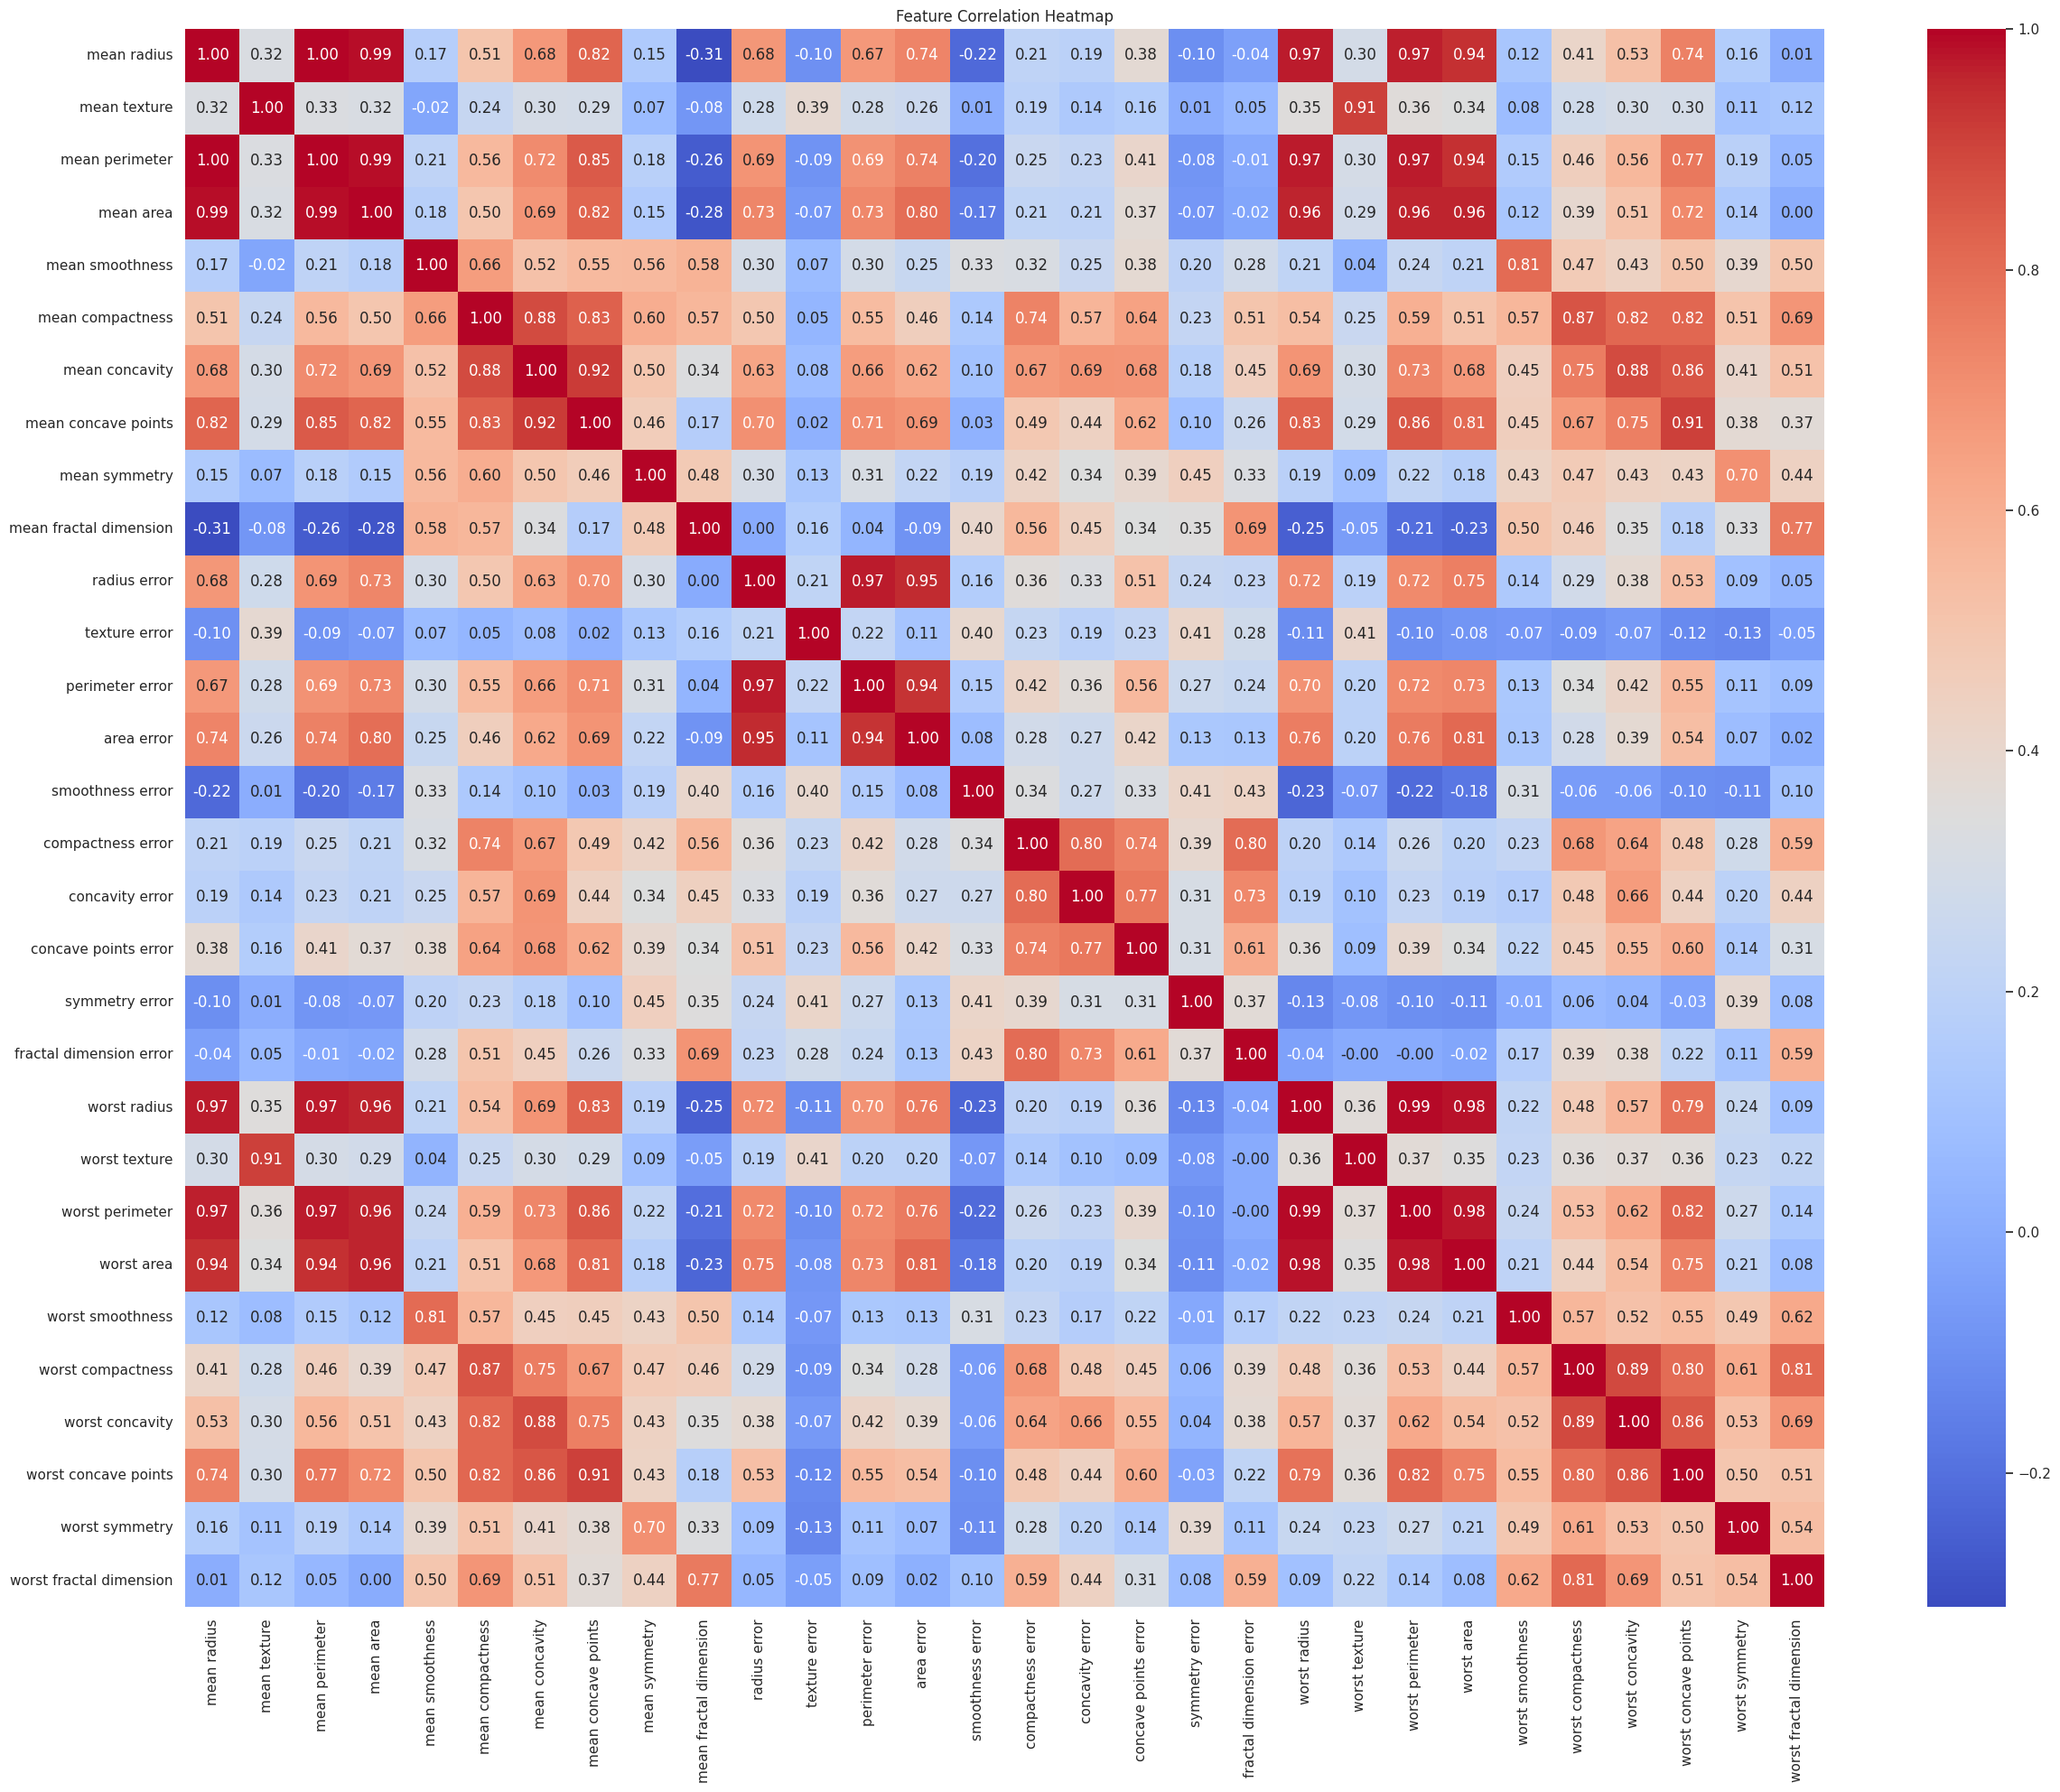


2. Bootstrap Feature Importance


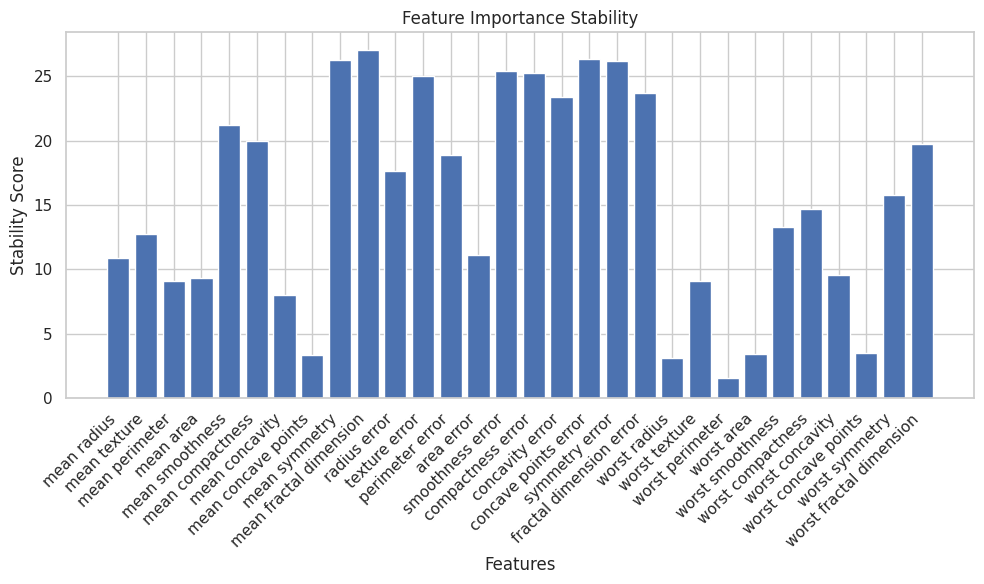


3. Outlier Impact Analysis


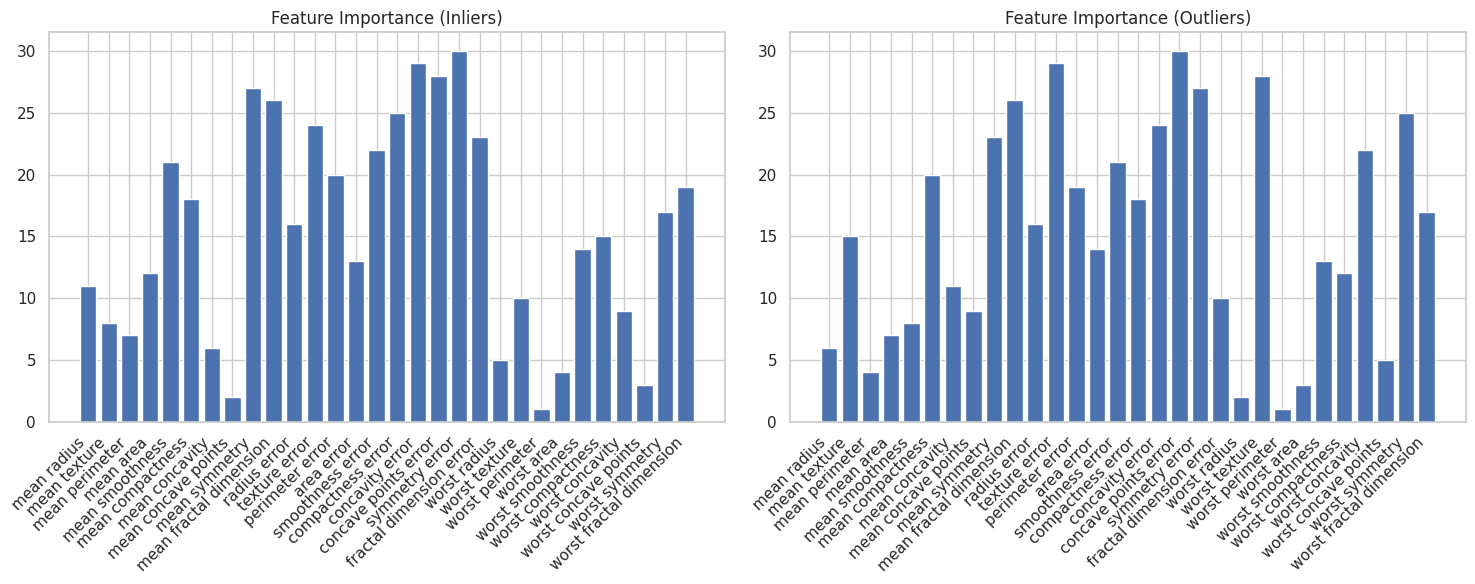


4. Learning Curves with Feature Reduction


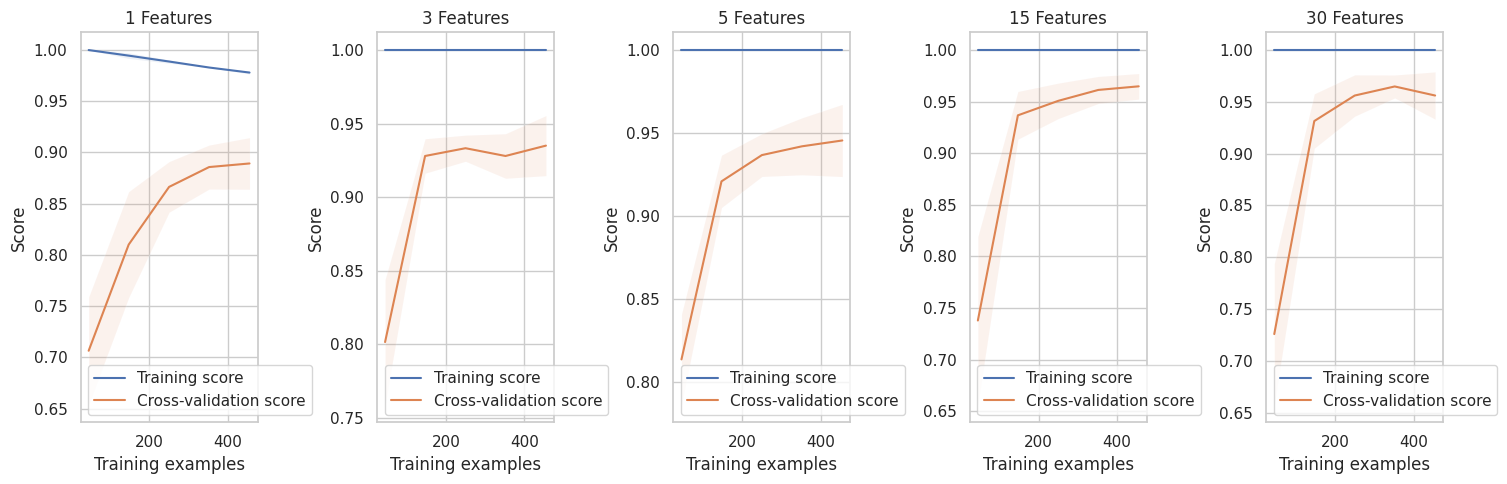


5. Feature Robustness Check


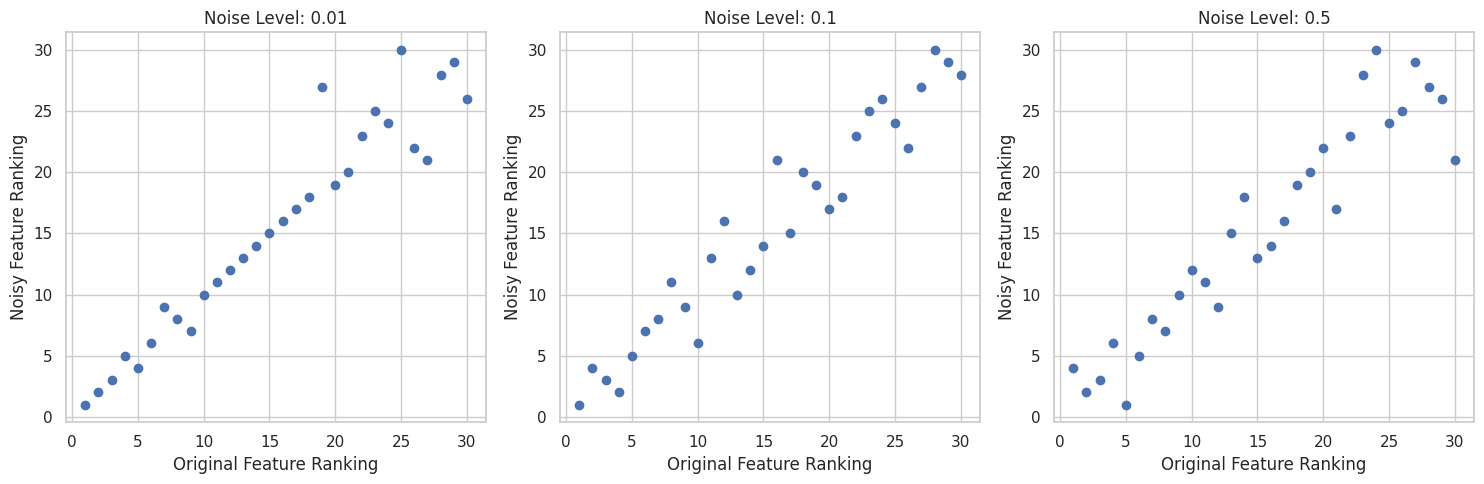



Regression Analysis with Diabetes Dataset

1. Feature Correlation Analysis


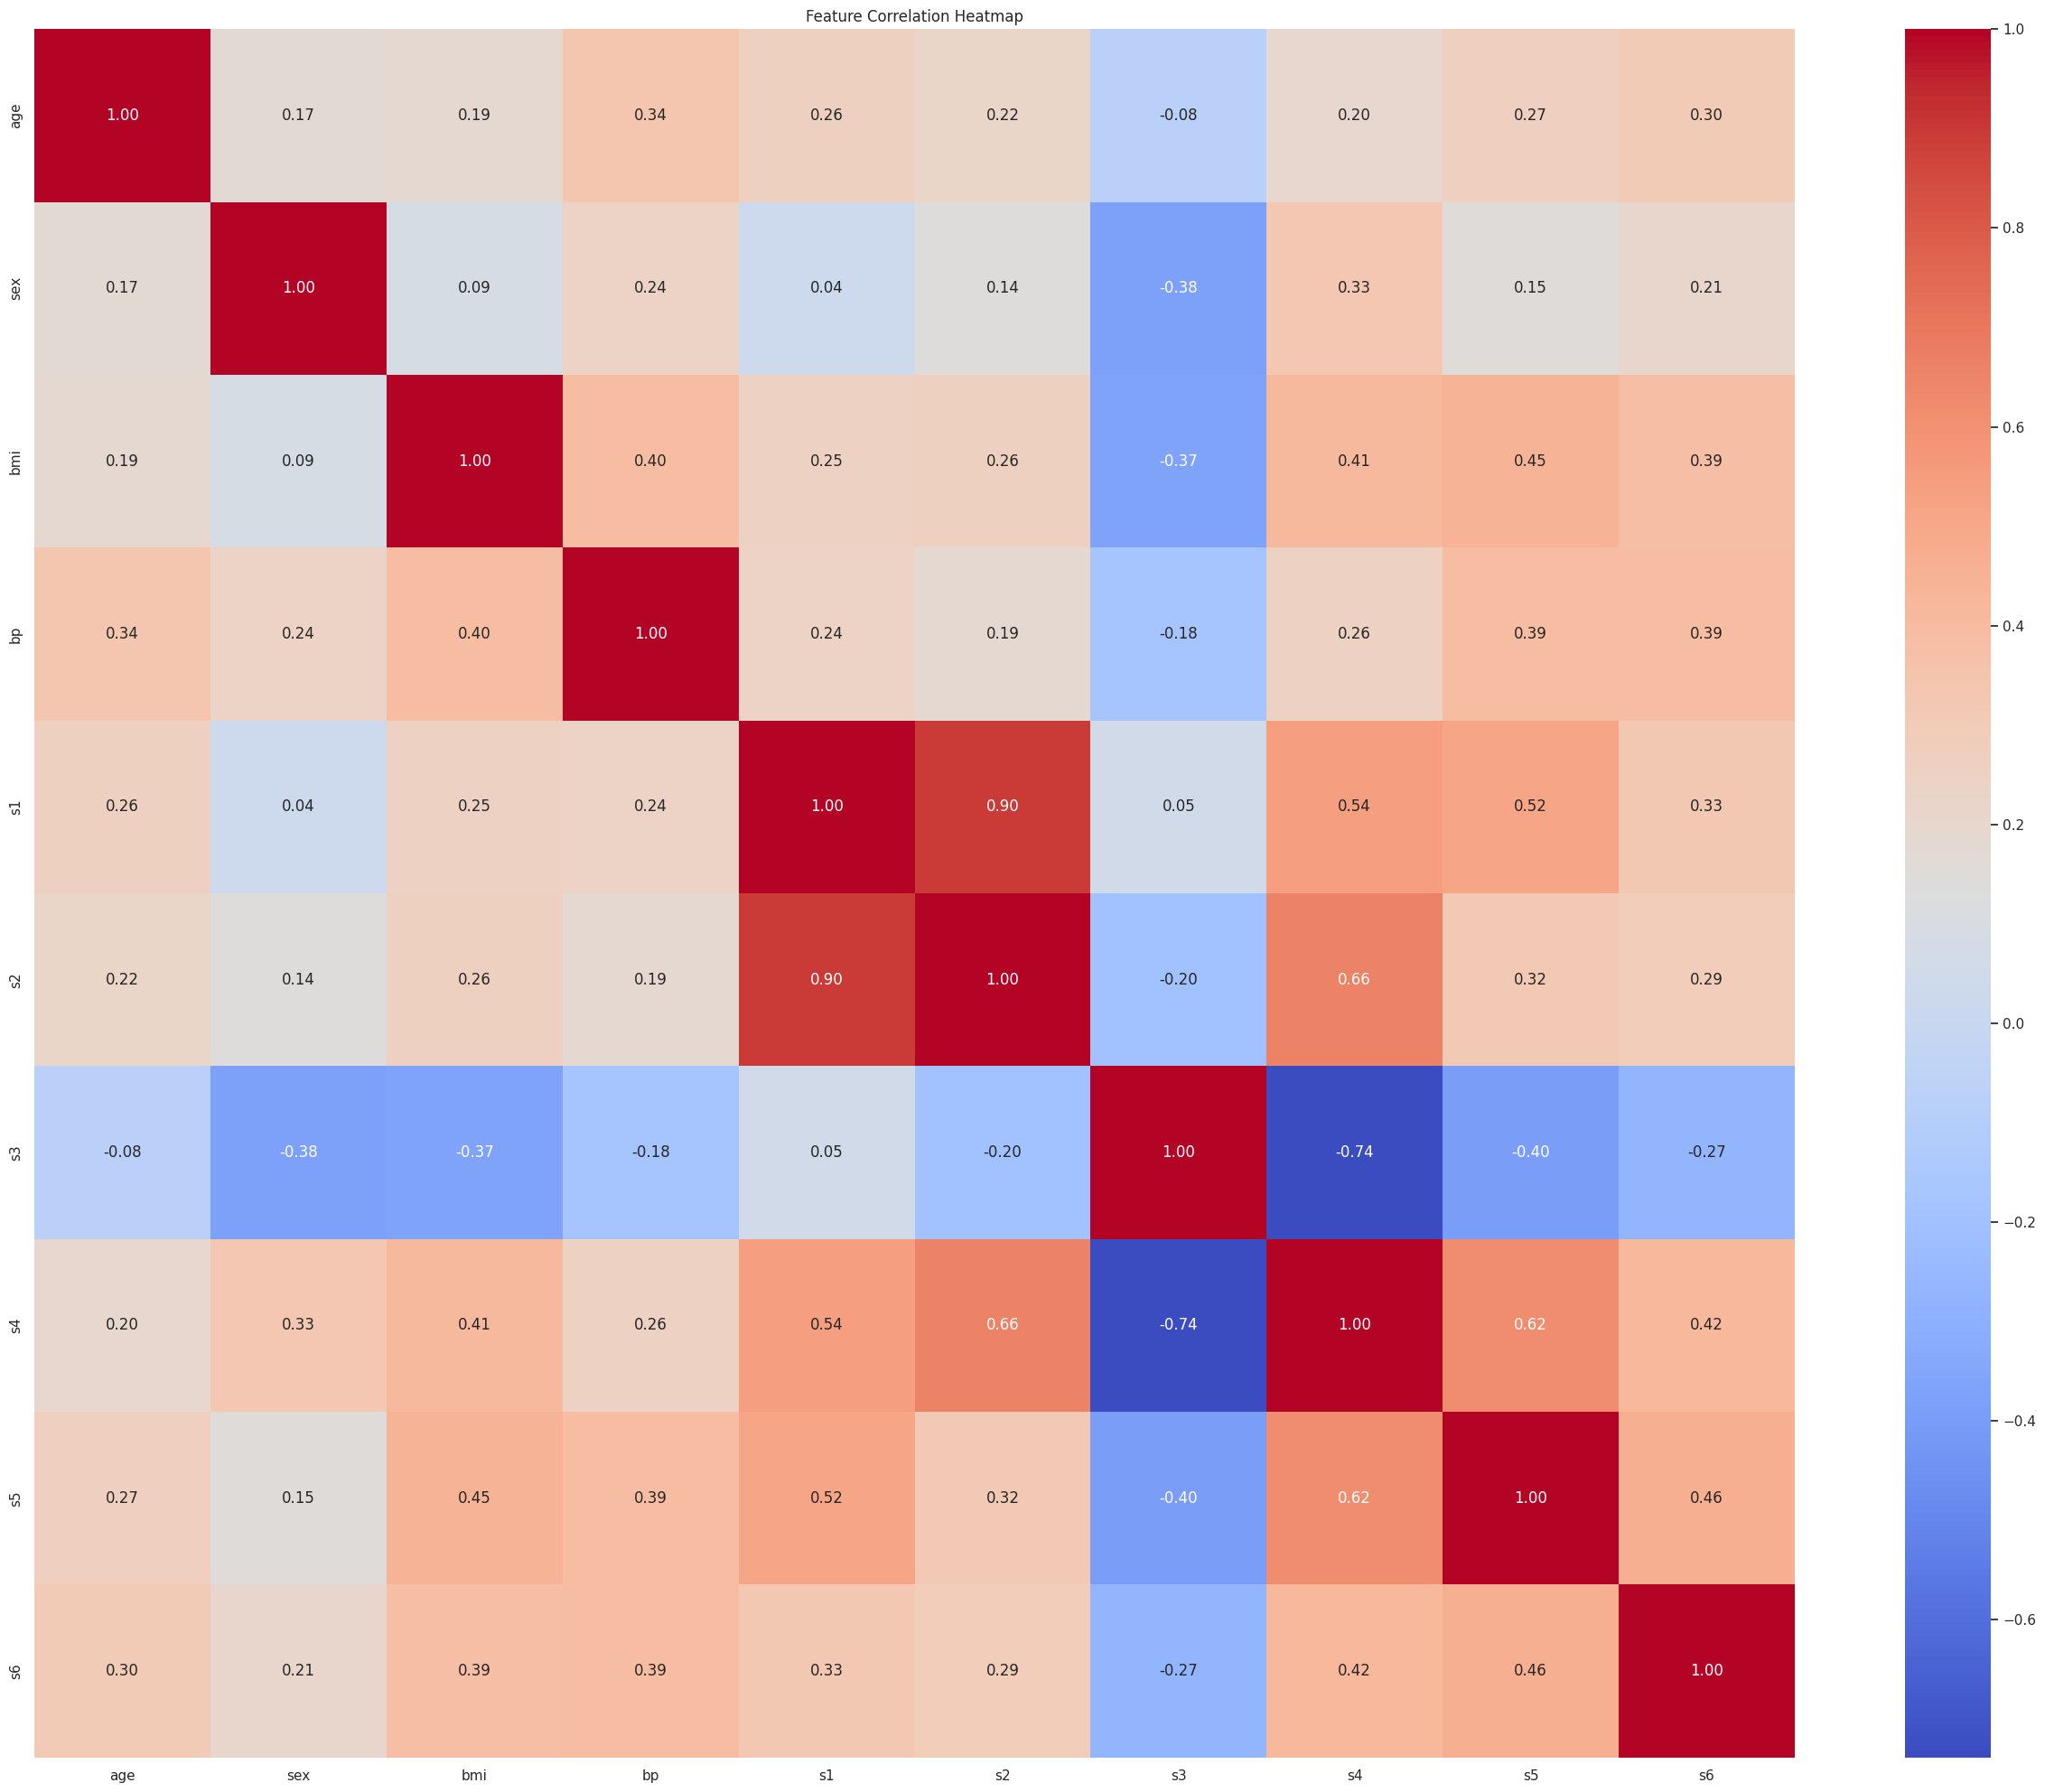


2. Bootstrap Feature Importance


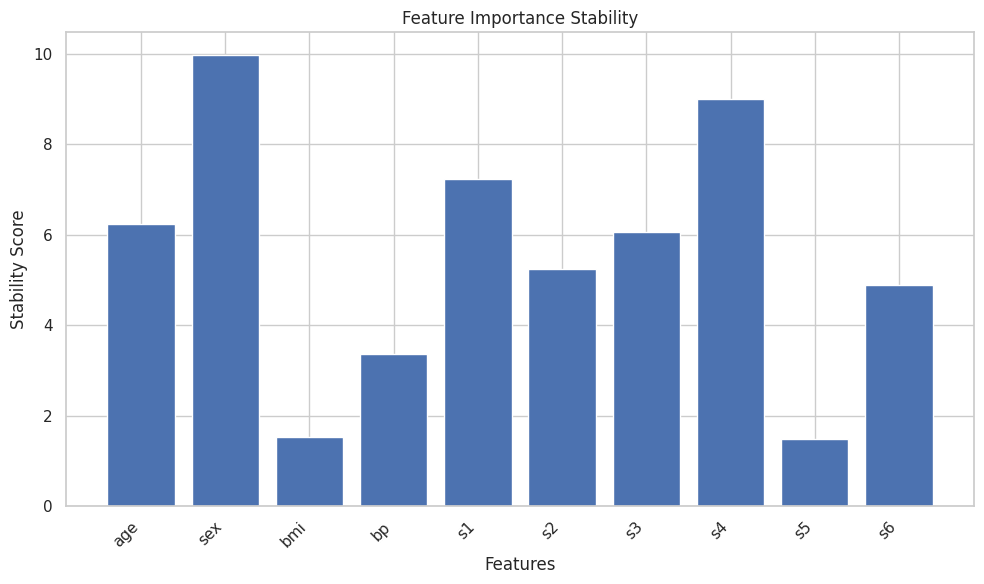

In [ ]:
def main():
    # Classification Example
    print("Classification Analysis with Breast Cancer Dataset")
    # Load Breast Cancer Dataset
    data = load_breast_cancer()
    X, y = data.data, data.target
    feature_names = data.feature_names

    # Preprocessing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Classification Models
    classification_models = [
        LogisticRegression(max_iter=1000),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42)
    ]

    # Perform additional analyses
    print("\n1. Feature Correlation Analysis")
    analyze_feature_correlations(X_scaled, feature_names)

    print("\n2. Bootstrap Feature Importance")
    bootstrap_feature_importance(X_scaled, y, RandomForestClassifier(random_state=42), feature_names)

    print("\n3. Outlier Impact Analysis")
    analyze_outlier_impact(X_scaled, y, feature_names)

    print("\n4. Learning Curves with Feature Reduction")
    plot_learning_curves_with_rfe(X_scaled, y, RandomForestClassifier(random_state=42), feature_names)

    print("\n5. Feature Robustness Check")
    check_feature_robustness(X_scaled, y, RandomForestClassifier(random_state=42), feature_names)

    # Regression Example
    print("\n\nRegression Analysis with Diabetes Dataset")
    # Load Diabetes Dataset
    data = load_diabetes()
    X, y = data.data, data.target
    feature_names = data.feature_names

    # Preprocessing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Regression Models
    regression_models = [
        LinearRegression(),
        RandomForestRegressor(random_state=42)
    ]

    # Perform additional analyses for regression
    print("\n1. Feature Correlation Analysis")
    analyze_feature_correlations(X_scaled, feature_names)

    print("\n2. Bootstrap Feature Importance")
    bootstrap_feature_importance(X_scaled, y, RandomForestRegressor(random_state=42), feature_names)


if __name__ == "__main__":
    main()

**Classification Analysis with Breast Cancer Dataset**

1. **Feature Correlation Analysis:**
The feature correlation heatmap reveals significant insights into the relationships between variables in the dataset and ties directly to the REF framework. Strong correlations among features like mean radius, mean perimeter, and mean area highlight redundancy, where overlapping information could lead to inefficiencies in modeling. Addressing these redundancies through feature removal or dimensionality reduction techniques like PCA enhances efficiency by reducing complexity and computation time. Additionally, features such as mean fractal dimension and symmetry error with weaker correlations contribute unique and diverse information, supporting robust feature selection. This analysis guides the creation of an optimized dataset, balancing redundancy and diversity for effective predictive modeling.

2. **Bootstrap Feature Importance:**
The graph demonstrates that feature importance can vary significantly based on the specific data sample used for training. To address this variability, the bootstrap feature importance technique repeatedly samples the dataset and applies Recursive Feature Elimination. This generates a stability score for each feature, revealing which ones are consistently important across different data subsets. Features with higher stability scores are more likely to be genuinely influential, rather than appearing important only by chance in a particular data sample. This approach provides a more reliable assessment of feature significance, which can be valuable for tasks like feature selection and model interpretation.

3. **Outlier Impact Analysis:**
 - "inliers" (data points that are considered normal and not outliers) :
 The features are ranked by their importance, with some features standing out as consistently more important than others.
 - "outliers" (data points that are considered anomalies or unusual cases) : This graph has a very different pattern, with some features that were not as important for the inliers becoming much more prominent for the outliers. This suggests that the outliers are influenced by different factors than the main data, and that analyzing the outliers separately can provide valuable insights.


4. **Learning Curves with Feature Reduction:**
As the number of features used in the model increases from 1 to 30, the graph shows the training and cross-validation scores. With just 1 feature, the training and cross-validation scores are quite low, but they steadily improve as more features are added. By the time 15 features are used, the model performance has stabilized and the training and cross-validation scores are quite high and close to each other, indicating the model is performing well.
The graphs demonstrate the value of feature reduction - using an optimal number of features can lead to high performance without overfitting. The specific number of features that provides the best balance depends on the dataset and task at hand.


5. **Feature Robustness Check:**
These graphs show how the "noisy feature ranking" (the ranking of features after adding noise to the data) changes as the level of noise increases.
At a low noise level of 0.01, the noisy feature ranking closely matches the original feature ranking, indicating the model is robust to this level of noise.
As the noise level increases to 0.1 and 0.5, the noisy feature ranking starts to deviate more from the original, showing the model is becoming less robust to higher levels of noise. Features that were ranked highly in the original may drop in ranking when noise is added.
This type of robustness check is important to understand how sensitive a model's feature importance is to data perturbations, which can help assess the reliability of the feature importance estimates.

**Regression Analysis with Diabetes Dataset**
1. **Feature Correlation Analysis:**
There is a notable positive correlation between features like s1, s2, and s3, which suggests redundancy. This indicates that these features may provide overlapping information, potentially increasing complexity and computational burden in modeling. Reducing such redundancies through techniques like dimensionality reduction or feature selection could improve efficiency. On the other hand, features such as age and sex exhibit weaker correlations with other variables, indicating that they offer unique information and contribute diversity to the model. By understanding these relationships, we can optimize the dataset, balancing redundancy and diversity, to enhance predictive modeling and overall model performance.

2. **Bootstrap Feature Importance Stability:**
The graph highlights the variability in feature importance across different training samples. Features like "sex" and "s4" have higher stability scores, suggesting they are consistently influential across multiple subsets of the data, while features with lower scores, such as "bmi" and "s5," may be less reliable indicators. This method provides a robust evaluation of feature significance, offering valuable insights for feature selection and model interpretation by focusing on features that consistently contribute to the model's performance.
